In [1]:
from cylp.cy import CyClpSimplex
from cylp.py.modeling.CyLPModel import CyLPArray

import pandas as pd
import numpy as np
import scipy.sparse as sps1
from copy import deepcopy
from datetime import *
import dateutil
from dateutil import parser, relativedelta
import pytz
import sys

import matplotlib.pyplot as plt
#import matplotlib.colors as mpl_colors

from simulationFunctions import *

from IPython.display import clear_output, display
import sys  # This is necessary for printing updates within a code block, via sys.stdout.flush()
import time # Use time.sleep(secs) to sleep a process if needed
%matplotlib inline

print("Current environment directory:" + sys.prefix)
print("System version: "+sys.version)

import warnings
warnings.simplefilter(action = "ignore", category = FutureWarning)

fs = 14
plt.rc('font',family='Times New Roman')
fn = 'Times New Roman'

Current environment directory:/usr/local/Cellar/python/2.7.12/Frameworks/Python.framework/Versions/2.7
System version: 2.7.12 (default, Aug 23 2016, 08:54:23) 
[GCC 4.2.1 Compatible Apple LLVM 7.3.0 (clang-703.0.31)]


In [2]:
# import price data as a dataframe: columns are times, rows are nodes.  Size is nodes x 8760
# fname = "/Users/emunsing/GoogleDrive/CE 290 Project/Data Collection/Prices/R code/All_PNodes_LMP_Aggregated_2013short.csv" #OUTDATED
# fname = "inputData/pricedata_LMP.csv" # FULL
# fname = "inputData/pricedata_LMP_100.csv" # Only 100 nodes
fname = "inputData/pricedata_LMP_5.csv" # Only 5 nodes

APNode_Prices = pd.read_csv( fname, header=0,index_col=0)#,nrows=10)
APNode_Prices.columns = pd.DatetimeIndex(APNode_Prices.columns,tz=dateutil.tz.tzutc())  # Note: This will be in UTC time. Use .tz_localize(pytz.timezone('America/Los_Angeles')) if a local time zone is desired- but note that this will 
timestep = relativedelta.relativedelta(APNode_Prices.columns[2],APNode_Prices.columns[1])
delta_T = timestep.hours  # Time-step in hours

## Deal with NaN prices
# Drop nodes which are above a cutoff
goodNodes = (APNode_Prices.isnull().sum(axis=1) < (0.02 * APNode_Prices.shape[1])) # True if node is less than x% NaN values
APNode_Prices = APNode_Prices[goodNodes]
# Interpolate remaining NaNs
APNode_Prices.interpolate(method='linear',axis=1)

print(APNode_Prices.shape)
APNode_Prices.head()

(5, 43848)


,2012-01-01 08:00:00+00:00,2012-01-01 09:00:00+00:00,2012-01-01 10:00:00+00:00,2012-01-01 11:00:00+00:00,2012-01-01 12:00:00+00:00,2012-01-01 13:00:00+00:00,2012-01-01 14:00:00+00:00,2012-01-01 15:00:00+00:00,2012-01-01 16:00:00+00:00,2012-01-01 17:00:00+00:00,...,2016-12-31 22:00:00+00:00,2016-12-31 23:00:00+00:00,2017-01-01 00:00:00+00:00,2017-01-01 01:00:00+00:00,2017-01-01 02:00:00+00:00,2017-01-01 03:00:00+00:00,2017-01-01 04:00:00+00:00,2017-01-01 05:00:00+00:00,2017-01-01 06:00:00+00:00,2017-01-01 07:00:00+00:00
WPBART_1_N004,29.07394,23.12437,21.44203,20.29711,20.40140,20.95670,21.32820,22.64024,24.72049,27.54177,...,33.04711,35.23429,41.98662,56.33175,50.36800,48.04914,44.82392,42.60931,40.00609,36.29630
FRNCHGLH_6_N001,29.81231,23.69904,21.95245,20.66600,20.76879,21.29364,21.65001,23.05594,25.26079,28.26455,...,31.24171,32.83757,39.84449,50.80030,45.31681,43.94770,41.57163,40.28760,37.06855,34.29119
EDENVALE_1_N006,29.25710,23.30524,21.59728,20.33898,20.45761,21.02284,21.53145,22.85926,24.88766,27.80806,...,32.54382,34.61978,41.28125,55.04994,49.36385,47.13025,44.02243,41.95502,39.48883,35.90417
HILLSIDE_1_N004,29.08253,23.13124,21.43352,20.27119,20.37128,20.92155,21.36843,22.69611,24.78106,27.66676,...,33.02811,35.19695,41.97360,56.28811,50.36800,48.03519,44.82392,42.60103,39.98678,36.30680
BARRY_6_N001,30.03553,23.89365,22.15024,20.87338,20.99565,21.55823,22.07767,23.48506,25.49338,28.41943,...,31.91277,33.95796,40.30114,53.68602,48.17384,46.03020,43.02173,41.10267,38.70523,35.13848


## Figure 1: Running fixed-size Efficiency Scenarios for charge/discharge validation
- fixed size (h = 1)
- Single node
- No storage cost 

In [6]:
startDate = parser.parse('08/01/13 00:00')  # year starts at 2013-01-01 00:00:00
endDate = parser.parse('08/03/13 06:00')  # year ends at 2013-12-31 23:00:00

timespan =  endDate + timestep - startDate  # Length of time series (integer)
simulationYears = (timespan.days*24 + timespan.seconds/3600) / 8760.  # Leap years will be slightly more than a year, and that's ok.
storagePrice = 0 * simulationYears # Amortized cost of storage

myEfficiencies = [0.6,0.8,0.9]
reservoirSize=1

E_min = 0
E_max = 1

nodeName = 'BARRY_6_N001'
myEnergyPrices = APNode_Prices.loc[nodeName,startDate:endDate].values / 1000.0
myLength = len(myEnergyPrices)
nans, x = nan_helper(myEnergyPrices)
myEnergyPrices[nans] = np.interp(x(nans), x(~nans), myEnergyPrices[~nans])

# Define cost function
c = np.concatenate([[storagePrice],[0]*(myLength+1),myEnergyPrices,myEnergyPrices],axis=0)  # No cost for storage state; charged for what we consume, get paid for what we discharge
c_clp = CyLPArray(c)
# Use the following section to force h to be a specific size:
h_constant = sps.hstack( [1, sps.coo_matrix((1, myLength*3+1))] );               
               
# Define model
model = CyClpSimplex()
x_var = model.addVariable('x',len(c))
model.objective = c_clp * x_var

print("Done with prep")

Done with prep


In [7]:
# Run loop through each Efficiency

resultDf = pd.DataFrame(columns=['storageSize','storageProfit','cycleCount','eState'])
results = {}

solverStartTime = time.time()

for eff_round in myEfficiencies:
    (eff_in, eff_out) = [np.sqrt(eff_round)] *2  # Properly account for the round trip efficiency of storage

    P_max = E_max/eff_in # Max discharge power, e.g max limit for C_i
    P_min = -1*E_max/eff_out # Max charge power, e.g. min D_i

    # Set up CyLP model
    (A, b, A_eq, b_eq) = createABMatrices(myLength, delta_T, eff_in, eff_out, P_min, P_max, E_min, E_max)

    # Force h to be a specific size:
    A_eq = sps.vstack( [h_constant, A_eq ] )
    b_eq = sps.vstack( [reservoirSize, b_eq] )

    # Define model
    model = CyClpSimplex()
    x_var = model.addVariable('x',len(c))
    model.objective = c_clp * x_var
    model += A * x_var <= b.toarray()
    model += A_eq * x_var == b_eq.toarray()
    
    model.primal()  # Solve

    x = model.primalVariableSolution['x']
    results['storageSize'] = x[0]
    results['storageProfit'] = np.dot(-c, x)   #Calculate profits at optimal storage level
    c_grid = x[2+myLength : 2+myLength*2]
    results['cycleCount'] = sum(c_grid)*eff_in # net kWh traveled
    results['eState'] = x[2 : myLength+2]
    
    resultDf.loc[str(eff_round),:] = results
    
solverEndTime = time.time()
clear_output()

print('Total function call time: %.3f seconds' % (solverEndTime - solverStartTime))

resultDf.to_csv('Data/SweepStorageEfficiency_BARRY_6_N001_ForPlotting.csv')

Total function call time: 0.095 seconds


0.6
0.8
0.9


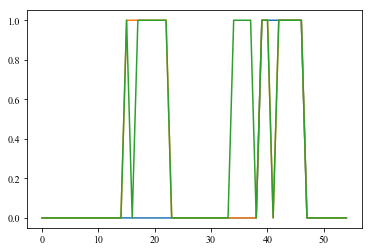

In [8]:
## Plotting and saving data for export

eStates = np.ndarray((resultDf.shape[0],myLength))
j = 0

for eff_round in resultDf.index: # ['1','4','8']: #
    print eff_round
    eStates[j,:] = resultDf.loc[eff_round,'eState']#/maxSize
    j = j+1
#    plt.plot(range(myLength),resultDf.loc[thisSize,'eState']/maxSize)

plt.plot(range(myLength),eStates.transpose())
    
np.savetxt('Data/chargeStates_efficiency.csv',eStates,delimiter=',')

## Experiment: Change prescribed storage size; plot profits

In [78]:
## THIS IS USED FOR THE PAPER
startDate = parser.parse('08/01/13 00:00')  # year starts at 2013-01-01 00:00:00
endDate = parser.parse('08/03/13 06:00')  # year ends at 2013-12-31 23:00:00

# This is for arbitrary length
startDate = parser.parse('01/01/13 00:00')  # year starts at 2013-01-01 00:00:00
endDate = parser.parse('06/30/13 23:00')  # year ends at 2013-12-31 23:00:00

# This is the full dataset
startDate = APNode_Prices.columns.values[ 0].astype('M8[m]').astype('O')
endDate   = APNode_Prices.columns.values[-1].astype('M8[m]').astype('O')

timespan =  endDate + timestep - startDate  # Length of time series (integer)
simulationYears = (timespan.days*24 + timespan.seconds/3600) / 8760.  # Leap years will be slightly more than a year, and that's ok.

storagePriceSet = [5]
storagePrice = storagePriceSet[0] * simulationYears # Amortized cost of storage

E_min = 0
E_max = 1

saveEState = False  # Switch this to 'True' if we want to save the charge history for plotting validation figures

## Market Price for desired APNode
numberOfNodes = APNode_Prices.shape[0] # number of nodes 

In [79]:
## Variable Set-up

# Manage efficiencies
myefficiencies = [0.9]

k = 0
eff_round = myefficiencies[k]  # Round-trip efficiency
(eff_in, eff_out) = [np.sqrt(eff_round)] *2  # Properly account for the round trip efficiency of storage

P_max = E_max/eff_in # Max discharge power, e.g max limit for C_i
P_min = -1*E_max/eff_out # Max charge power, e.g. min D_i

myNodeName = 'BARRY_6_N001' # Use this if we're just interested in a specific node

myEnergyPrices = APNode_Prices.loc[myNodeName,startDate:endDate] / 1000. # Price $/kWh as array
myLength = len(myEnergyPrices)

# Deal with NaN entries in price series
nans, x = nan_helper(myEnergyPrices)
myEnergyPrices[nans] = np.interp(x(nans), x(~nans), myEnergyPrices[~nans])

In [80]:
# Set up CyLP model

# Create A-matrices once efficiency is specified
(A, b, A_eq, b_eq) = createABMatrices(myLength, delta_T, eff_in, eff_out, P_min, P_max, E_min, E_max)

# Define cost function
c = np.concatenate([[storagePrice],[0]*(myLength+1),myEnergyPrices,myEnergyPrices],axis=0)  # No cost for storage state; charged for what we consume, get paid for what we discharge

# Define model
model = CyClpSimplex()
x_var = model.addVariable('x',len(c))
c_clp = CyLPArray(c)
model.objective = c_clp * x_var

# Use the following section to force h to be a specific size:
h_constant = sps.hstack( [1, sps.coo_matrix((1, myLength*3+1))] );
A_eq = sps.vstack( [h_constant, A_eq ] )
b_eq = sps.vstack( [1, b_eq] )  # the 1 here will be overwritten by the reservoir size later

# Add constraints to model
model += A * x_var <= b.toarray()
model += A_eq * x_var == b_eq.toarray()

Length = 43848
Size of A    (aka G): 263091 x 131546
Size of b    (aka h): 263091 x 1
Size of A_eq (aka A): 43849 x 131546
Size of B_eq (aka b): 43849 x 1


In [ ]:
# Run loop through each storage size

storageSizes = np.arange(0,10,0.1)
# storageSizes = [2,6,12,18]
resultDf = pd.DataFrame(columns=['storageSize','storageProfit','cycleCount','eState'])
results = {}

solverStartTime = time.time()

for j in storageSizes:
    # Change mandated size of system: want to set the upper and lower bounds of the first inequality constraint (index is len(a.toarray()))
    model.setRowUpper(b.shape[0],j)
    model.setRowLower(b.shape[0],j)

    model.primal()  # Solve

    x = model.primalVariableSolution['x']
    results['storageSize'] = x[0]
    results['storageProfit'] = np.dot(-c, x)   #Calculate profits at optimal storage level
    e_state = x[2 : myLength+2]
    c_grid = x[2+myLength : 2+myLength*2]
    #d_grid = x[2+myLength*2 : ]
    #p_batt = c_grid + d_grid
    results['cycleCount'] = sum(c_grid)*eff_in # net kWh traveled
    
    if saveEState:
        results['eState'] = e_state
    
    resultDf.loc[str(j),:] = results
    #resultDf.append(results.values(), columns = ['storageSize','storageProfit','cycleCount'], ignore_index=True)
    #print('Size: \t %.4f \t Profits: \t %.4f \t Cycle Count: %.4f' % tuple(results.values()))
    
resultDf['annualStorageProfit'] = resultDf['storageProfit'] / simulationYears

solverEndTime = time.time()
clear_output()

#print('Storage size: %.4f' % storageSize)
print('Total function call time: %.3f seconds' % (solverEndTime - solverStartTime))
#print('Profits: %4f' % storageProfit)

resultDf.to_csv('Data/SweepStorageSize_ForPlotting.csv')

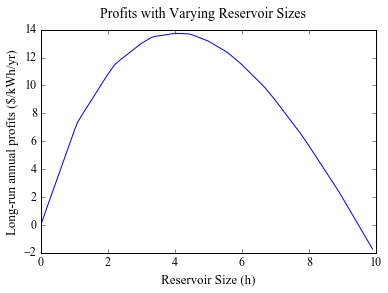

In [84]:
## Plot Results ## 
fs = 12

plt.plot(resultDf['storageSize'],resultDf['annualStorageProfit'])
plt.xlabel('Reservoir Size (h)', fontsize=fs+1)
plt.ylabel('Long-run annual profits ($/kWh/yr)', fontsize=fs+1)
plt.suptitle('Profits with Varying Reservoir Sizes', fontsize= fs+2)

plt.savefig('Plots/Profit_VaryingSize.pdf',bbox_inches='tight')

ax = plt.subplot()
for label in (ax.get_xticklabels() + ax.get_yticklabels()):
    #label.set_fontname('Arial')
    label.set_fontsize(fs)

##Experiment: Vary pricing
`Initial solve: cold start
 For each node:
    Check last initial solve
    Change c matrix- new price data, new cost data
    Solve and save node, profit, cycle count, size
    Copy problem into future iterations
    
    Sweep storage price
        Modify price entry of c matrix
        save results
`

## Validation: plotting charge status for different reservoir sizes
Refined plotting is handled in 'Plots for APEN.ipynb'

1.0
2.0
6.0


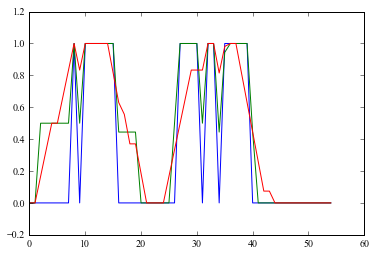

In [16]:
resultSample = [1,2,6]

eStates = np.ndarray([myLength,len(resultSample)])
j = 0

for thisSize in resultSample: #
    maxSize = float(thisSize)
    print maxSize
    eStates[:,j] = resultDf.loc[str(thisSize),'eState']/maxSize
    j = j+1
#    plt.plot(range(myLength),resultDf.loc[thisSize,'eState']/maxSize)

plt.plot(range(myLength),eStates)
    
np.savetxt('Data/chargeStates_varySize.csv',eStates,delimiter=',')

# Sweep Price, Plot optimal size of all nodes

In [14]:
def computePriceSweep(thisSlice):
    ###### BEGINNING OF MULTIPROCESSING FUNCTION ###########
    myLength = thisSlice.shape[1]

    # Simulation parameters - set these!
    storagePriceSet = np.arange(1.0,20.1,0.1)
    storagePriceSet = np.arange(1.0,3.1,1)
    eff_round = 0.9  # Round-trip efficiency
    E_min = 0
    E_max = 1

    # Endogenous parameters; calculated automatically
    (eff_in, eff_out) = [np.sqrt(eff_round)] *2  # Properly account for the round trip efficiency of storage
    P_max = E_max/eff_in # Max discharge power at grid intertie, e.g max limit for C_i
    P_min = -1*E_max/eff_out # Max charge power at grid intertie, e.g. min D_i

    # Create a result dataframe
    resultIndex = pd.MultiIndex.from_product([thisSlice.index,['size','kwhPassed','profit']])
    results = pd.DataFrame(index = resultIndex, columns=storagePriceSet)

    # Create clean problem matrices - needs efficiency and length!
    (A, b, A_eq, b_eq) = createABMatrices(myLength, delta_T, eff_in, eff_out, P_min, P_max, E_min, E_max)
    # Define model:
    coolStart = CyClpSimplex()
    coolStart.logLevel = 0
    x_var = coolStart.addVariable('x',myLength*3+2)
    # Add constraints to model:
    coolStart += A * x_var <= b.toarray()
    coolStart += A_eq * x_var == b_eq.toarray()
    # print("Finished with problem setup")
    # sys.stdout.flush()

    # everythingStarts = time.time()
    # startTime = time.time()

    for myNodeName in thisSlice.index:
        ## Set up prices
    #     myNodeName = thisSlice.index[i]
        energyPrice = thisSlice.loc[myNodeName,:] / 1000.0 # Price $/kWh as array

        c = np.concatenate([[0.0],[0.0]*(myLength+1),energyPrice,energyPrice],axis=0)  #placeholder; No cost for storage state; charged for what we consume, get paid for what we discharge
        #[[storagePricePlaceholder],[0]*(myLength+1),myPrice,myPrice],axis=1)
        c_clp = CyLPArray(c)

        sweepStartTime = time.time()

        for myStoragePrice in storagePriceSet:
            c_clp[0] = myStoragePrice * simulationYears
            coolStart.objective = c_clp * x_var

            # Run the model
            coolStart.primal()

            # Results- Rows are Nodes, indexed by name. Columns are Storage price, indexed by price
            x_out = coolStart.primalVariableSolution['x']
            results.loc[(myNodeName,'size'),     myStoragePrice] = x_out[0]
            results.loc[(myNodeName,'profit'),   myStoragePrice] = np.dot(-c, x_out)
            results.loc[(myNodeName,'kwhPassed'),myStoragePrice] = sum(x_out[2+myLength : 2+myLength*2]) * eff_in # Note: this is the net power pulled from the grid, not the number of cycles when the system is unconstrained

        storagePriceSet = storagePriceSet[::-1] # Reverse the price set so that we start from the same price for the next node to make warm-start more effective

    #     if ((i+1) % reportFrequency == 0): # Save our progress along the way
    #         elapsedTime = time.time()-startTime
    #         print("Finished node %s; \t%s computations in \t%.4f s \t(%.4f s/solve)" 
    #               % (i, scenariosPerReport,elapsedTime,elapsedTime/scenariosPerReport))
    #         sys.stdout.flush()
    #         sizeDf.to_csv('Data/VaryingPrices_StorageSizing_v2.csv')
    #         profitDf.to_csv('Data/VaryingPrices_StorageProfits_v2.csv')
    #         cycleDf.to_csv('Data/VaryingPrices_StorageCycles_v2.csv')

    # print("Done in %.3f s"%(time.time()-everythingStarts))
    return results

In [15]:

## CUSTOM START/END DATE
startDate = parser.parse('01/01/12 00:00')  # year starts at 2013-01-01 00:00:00
endDate = parser.parse('01/31/12 23:00')  # year ends at 2013-12-31 23:00:00
startDate = pytz.timezone('America/Los_Angeles').localize(startDate).astimezone(pytz.utc)
endDate = pytz.timezone('America/Los_Angeles').localize(endDate).astimezone(pytz.utc)

# ## FULL DATASET
# startDate = APNode_Prices.columns.values[ 0].astype('M8[m]').astype('O') # Convert to datetime, not timestamp
# endDate   = APNode_Prices.columns.values[-1].astype('M8[m]').astype('O')
# startDate = pytz.utc.localize(startDate)
# endDate   = pytz.utc.localize(endDate)

timespan = relativedelta.relativedelta(endDate +timestep, startDate)
simulationYears = timespan.years + timespan.months/12. + timespan.days/365. + timespan.hours/8760.  # Leap years will be slightly more than a year, and that's ok.

startNode = 0
stopNode  = 0 # if set to zero, then will loop through all nodes
if ((stopNode == 0)|(stopNode > APNode_Prices.shape[0])): stopNode = APNode_Prices.shape[0]

    
thisSlice = APNode_Prices.ix[startNode:stopNode,startDate:endDate]
# someResults = computePriceSweep(APNode_Prices)


import multiprocessing

# Split dataset into roughly even chunks
j = min(multiprocessing.cpu_count(),10)
# chunksize = (APNode_Prices.shape[0]/j)+1
# splitFrames = [df for g,df in APNode_Prices.groupby(np.arange(APNode_Prices.shape[0])//chunksize)]
chunksize = (thisSlice.shape[0]/j)+1
splitFrames = [df for g,df in thisSlice.groupby(np.arange(thisSlice.shape[0])//chunksize)]

pool = multiprocessing.Pool(processes = j)
resultList = pool.map(computePriceSweep,splitFrames)
joinedResults = pd.concat(resultList)

joinedResults.sort_index(inplace=True)
sizeDf   = joinedResults.loc[(slice(None),'size'),:].reset_index(level=1,drop=True)
profitDf = joinedResults.loc[(slice(None),'profit'),:].reset_index(level=1,drop=True)
cycleDf  = joinedResults.loc[(slice(None),'kwhPassed'),:].reset_index(level=1,drop=True)

sizeDf.to_csv('Data/VaryingPrices_StorageSizing_v2.csv')
profitDf.to_csv('Data/VaryingPrices_StorageProfits_v2.csv')
cycleDf.to_csv('Data/VaryingPrices_StorageCycles_v2.csv')

Length = 744
Length = 744
Size of A    (aka G): 4467 x 2234
Size of b    (aka h): 4467 x 1
Size of A_eq (aka A): 745 x 2234
Size of B_eq (aka b): 745 x 1
Size of A    (aka G): 4467 x 2234
Size of b    (aka h): 4467 x 1
Size of A_eq (aka A): 745 x 2234
Size of B_eq (aka b): 745 x 1


1.0       2.0      3.0
WPBART_1_N004   size             6         5        4
                kwhPassed  225.222   203.778  176.889
                profit     1.34461  0.892552  0.53293
FRNCHGLH_6_N001 size             6         5        4
                kwhPassed  219.778   199.111  173.111

# Storage Price Sweep - Serial Approach

In [ ]:
## Model Set-up

# Note: the following is a list of 200 nodes with node codes that begin
# with unique 4-letter prefixes. This should help to create a random sample of prices and geographies
#uniqueNodes = [1,2,3,4,5,6,20,22,23,24,25,27,33,34,36,37,38,39,42,43,44,45,46,47,48,49,50,51,54,56,57,58,59,60,62,65,68,69,71,73,74,76,78,82,83,86,87,88,89,91,92,93,94,95,101,104,106,107,110,114,116,117,118,122,124,125,131,134,135,137,142,143,144,150,151,152,153,154,157,158,160,166,167,169,172,173,174,176,177,178,179,180,182,187,188,189,190,193,196,199,200,202,205,206,208,211,213,224,229,230,233,237,240,242,243,244,245,246,248,249,250,252,254,256,257,260,261,264,266,272,274,276,278,279,281,282,285,287,288,290,292,293,297,300,302,305,307,308,309,310,314,315,316,317,318,320,324,328,329,332,333,335,338,340,341,342,344,346,347,352,357,359,360,364,368,369,371,375,376,377,380,382,386,387,388,393,395,396,405,406,408,410,413,416,418,420,421,423,426,432]

# Computational burden is superlinear, so break into 1-year chunks. 1 year computes in about 0.25s per node after cold start; 5-year dataset takes >4min for solve

startDate = parser.parse('01/01/13 00:00')  # year starts at 2013-01-01 00:00:00
endDate = parser.parse('12/31/13 23:00')  # year ends at 2013-12-31 23:00:00

# Full dataset
# startDate = APNode_Prices.columns.values[ 0].astype('M8[m]').astype('O')
# endDate   = APNode_Prices.columns.values[-1].astype('M8[m]').astype('O')

timespan =  endDate + timestep - startDate  # Length of time series (integer)
simulationYears = (timespan.days*24 + timespan.seconds/3600) / 8760.  # Leap years will be slightly more than a year, and that's ok.
myLength = APNode_Prices.columns.get_loc(endDate) - APNode_Prices.columns.get_loc(startDate)+1

eff_round = 0.9  # Round-trip efficiency
(eff_in, eff_out) = [np.sqrt(eff_round)] *2  # Properly account for the round trip efficiency of storage

E_min = 0
E_max = 1
P_max = E_max/eff_in # Max discharge power at grid intertie, e.g max limit for C_i
P_min = -1*E_max/eff_out # Max charge power at grid intertie, e.g. min D_i

# Create clean problem matrices - first specify efficiency!
(A, b, A_eq, b_eq) = createABMatrices(myLength, delta_T, eff_in, eff_out, P_min, P_max, E_min, E_max)
# Define model:
coolStart = CyClpSimplex()
x_var = coolStart.addVariable('x',myLength*3+2)
# Add constraints to model:
coolStart += A * x_var <= b.toarray()
coolStart += A_eq * x_var == b_eq.toarray()

Length = 8760
Size of A    (aka G): 52563 x 26282
Size of b    (aka h): 52563 x 1
Size of A_eq (aka A): 8761 x 26282
Size of B_eq (aka b): 8761 x 1


In [ ]:
## LOOP BLOCK- loops through nodes, and then for each node loops through each price

## Sweep storage price
#storagePriceSet = [5,5.1,19.9, 20]
storagePriceSet = np.arange(1.0,20.1,0.1) #np.arange(1,20,0.1)

startNode = 0
stopNode = 0 # if set to zero, then will loop through all nodes
if ((stopNode == 0)|(stopNode > APNode_Prices.shape[0])): stopNode = APNode_Prices.shape[0]

# Initializing variables for loop
myStoragePrice = storagePriceSet[0]
badNodes = []
sizeDf = pd.DataFrame()
profitDf = pd.DataFrame()
cycleDf = pd.DataFrame()
                          
for i in range(startNode,stopNode):
    ## Set up prices
    myNodeName = APNode_Prices.index[i]
    energyPrice = APNode_Prices.loc[myNodeName,startDate:endDate] / 1000.0 # Price $/kWh as array

    # Deal with NaN prices
    nodePriceNanCount = sum(np.isnan(energyPrice))
    if (0.05 < (nodePriceNanCount/myLength)):  # Set cutoff threshold here
        badNodes.push(i) # Add this to the list of bad nodes
        continue # Jump to the next node
    nans, x = nan_helper(energyPrice)
    energyPrice[nans] = np.interp(x(nans), x(~nans), energyPrice[~nans])

    c = np.concatenate([[0.0],[0.0]*(myLength+1),energyPrice,energyPrice],axis=0)  #placeholder; No cost for storage state; charged for what we consume, get paid for what we discharge
    #[[storagePricePlaceholder],[0]*(myLength+1),myPrice,myPrice],axis=1)
    c_clp = CyLPArray(c)

    sweepStartTime = time.time()

    for myStoragePrice in storagePriceSet:
        c_clp[0] = myStoragePrice * simulationYears
        coolStart.objective = c_clp * x_var

        # Run the model
        startTime = time.time()
        coolStart.primal()
        endTime = time.time()

        # Results- Rows are Nodes, indexed by name. Columns are Storage price, indexed by price
        x_out = coolStart.primalVariableSolution['x']
        sizeDf.loc[myNodeName,str(myStoragePrice)]   = x_out[0]
        profitDf.loc[myNodeName,str(myStoragePrice)] = np.dot(-c, x_out)
        cycleDf.loc[myNodeName,str(myStoragePrice)]  = sum(x_out[2+myLength : 2+myLength*2]) * eff_in
#         print("Finished with initial solve in \t%.4f s for node %s" % ((endTime-startTime),myNodeName))
        sys.stdout.flush()
    
    sweepTime = time.time()-sweepStartTime
    print("Finished %s computations in \t%.4f s for node %s \t(%.4f s/solve)" % (len(storagePriceSet), sweepTime, myNodeName, sweepTime/(len(storagePriceSet)-1) ))
    sys.stdout.flush()
    storagePriceSet = storagePriceSet[::-1] # Reverse the price set so that we start from the same price for the next node to make warm-start more effective

    if (i % 10 == 0): # Save our progress along the way
        sizeDf.to_csv('Data/VaryingPrices_StorageSizing_v2.csv')
        profitDf.to_csv('Data/VaryingPrices_StorageProfits_v2.csv')
        cycleDf.to_csv('Data/VaryingPrices_StorageCycles_v2.csv')
    
#clear_output()
print("Finished; writing all to file...")
sizeDf.to_csv('Data/VaryingPrices_StorageSizing_v2.csv')
profitDf.to_csv('Data/VaryingPrices_StorageProfits_v2.csv')
cycleDf.to_csv('Data/VaryingPrices_StorageCycles_v2.csv')


Finished 191 computations in 	85.5360 s for node BSPHYD26_7_N001 	(0.4502 s/solve)
Finished 191 computations in 	44.3449 s for node CHCGOPK_1_B1 	(0.2334 s/solve)
Finished 191 computations in 	41.1565 s for node CHSTN_1_N001 	(0.2166 s/solve)
Finished 191 computations in 	46.9362 s for node CONTROLX_1_N002 	(0.2470 s/solve)
Finished 191 computations in 	52.2762 s for node TELECYN_1_N014 	(0.2751 s/solve)
Finished 191 computations in 	40.2232 s for node CAWELOB_6_N001 	(0.2117 s/solve)
Finished 191 computations in 	36.4001 s for node LOGANCR_2_N001 	(0.1916 s/solve)
Finished 191 computations in 	36.9659 s for node BUENAVS2_7_B5 	(0.1946 s/solve)
Finished 191 computations in 	38.5215 s for node PIT5_7_B1 	(0.2027 s/solve)
Finished 191 computations in 	37.4975 s for node CORTINA_1_N106 	(0.1974 s/solve)
Finished 191 computations in 	40.6968 s for node MCFRLND_6_N001 	(0.2142 s/solve)
Finished 191 computations in 	40.2367 s for node ALLEGHNY_6_N001 	(0.2118 s/solve)
Finished 191 computatio

### Plotting results from storage price sweep

In [8]:
sizeDf = pd.read_csv('Data/VaryingPrices_StorageSizing_v2.csv',header=0,index_col=0)
profitDf = pd.read_csv('Data/VaryingPrices_StorageProfits_v2.csv',header=0,index_col=0)
cycleDf = pd.read_csv('Data/VaryingPrices_StorageCycles_v2.csv',header=0,index_col=0)

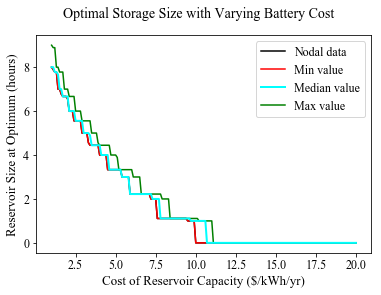

In [13]:
myDf = sizeDf # assume that columns are different simulations and rows are observations
x = myDf.columns.astype(float)
fs = 12

# Need to save the handles for the items that we want in the legend
# Because plotted main data with tiny opacity, will need to re-plot with black and save data
ax = plt.subplot()
plt.plot(x,myDf.transpose(),alpha=0.01, color='black')
dataHdl, = plt.plot(x,myDf.min(), color='black') # This will be covered up; we just use this for the legend
minHdl, = plt.plot(x,myDf.min(), color='red')
maxHdl, = plt.plot(x,myDf.max(), color='green')
medHdl, = plt.plot(x,myDf.median(), color='cyan',linewidth=2)

for label in (ax.get_xticklabels() + ax.get_yticklabels()):
    #label.set_fontname('Arial')
    label.set_fontsize(fs)

plt.xlabel('Cost of Reservoir Capacity ($/kWh/yr)',fontsize=fs+1)
plt.ylabel('Reservoir Size at Optimum (hours)',fontsize=fs+1)
plt.suptitle('Optimal Storage Size with Varying Battery Cost',fontsize=fs+2)
plt.legend([dataHdl,minHdl,medHdl, maxHdl],['Nodal data','Min value','Median value','Max value'],loc='upper right',fontsize=fs)
plt.savefig('Plots/VaryingPrices_storageCapacity.pdf',bbox_inches='tight')
#plt.savefig('kwhValue.png', dpi=300, bbox_inches='tight')

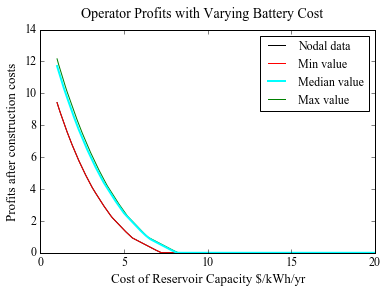

In [89]:
myDf = profitDf # assume that columns are different simulations and rows are observations
x = myDf.columns.astype(float)
fs = 12

# Need to save the handles for the items that we want in the legend
# Because plotted main data with tiny opacity, will need to re-plot with black and save data
ax = plt.subplot()
plt.plot(x,myDf.transpose(),alpha=0.01, color='black')
dataHdl, = plt.plot(x,myDf.min(), color='black') # This will be covered up; we just use this for the legend
minHdl, = plt.plot(x,myDf.min(), color='red')
maxHdl, = plt.plot(x,myDf.max(), color='green')
medHdl, = plt.plot(x,myDf.median(), color='cyan',linewidth=2)

for label in (ax.get_xticklabels() + ax.get_yticklabels()):
    #label.set_fontname('Arial')
    label.set_fontsize(fs)

plt.xlabel('Cost of Reservoir Capacity $/kWh/yr',fontsize=fs+1)
plt.ylabel('Profits after construction costs',fontsize=fs+1)
plt.suptitle('Operator Profits with Varying Battery Cost',fontsize=fs+2)
plt.legend([dataHdl,minHdl,medHdl, maxHdl],['Nodal data','Min value','Median value','Max value'],loc='upper right',fontsize=fs)
plt.savefig('Plots/VaryingPrices_storageProfit.pdf',bbox_inches='tight')
#plt.savefig('kwhValue.png', dpi=300, bbox_inches='tight')

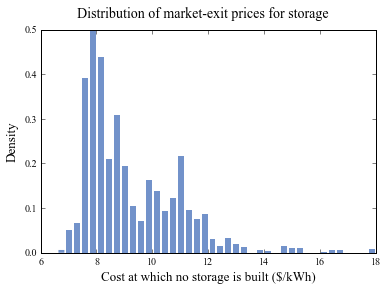

In [13]:
## Plotting histogram of price at which storage system will no longer operate
# i.e. the cost at which no storage is built
# This should match our results from the earlier optimization (dispatch without sizing)

myDf = sizeDf
#myDf = sizeDf.iloc[0:9,:]

maxCost = pd.Series()

for thisRowName in myDf.index:
    thisRow = myDf.loc[thisRowName,:]
    maxCost[thisRowName] = float(thisRow[thisRow < 0.01].index[0])

#plt.hist(maxCost,40,histtype='bar',rwidth=0.75)
n, bins, patches = plt.hist(maxCost,40,normed=1,histtype='bar',rwidth=0.75, label= 'Nodal profits $/kWh/year, \n90% efficiency',linewidth=0, facecolor= (114/256.,147/256.,203/256.),)

plt.xlabel('Cost at which no storage is built ($/kWh)',fontsize=fs+1)
plt.ylabel('Density',fontsize=fs+1)
plt.suptitle('Distribution of market-exit prices for storage',fontsize=fs+2)
                            
## This matches the plot that we made from our previous research, to within rounding error introduced by our limited step size


Min price at which 4hr storage is optimal: 	2.9 
Avg price at which 4hr storage is optimal: 	4.55242545616 
Median price at which 4hr storage is optimal: 	4.2 
Max price at which 4hr storage is optimal: 	7.0 


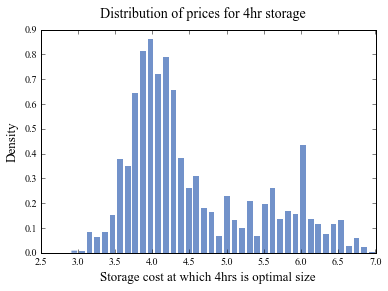

In [14]:
## Plotting histogram of price at which 4 hours of storage is built
# this is relevant because many storage systems are targeting a 4hr duration

myDf = sizeDf
#myDf = sizeDf.iloc[0:9,:]

maxCost = pd.Series()

for thisRowName in myDf.index:
    thisRow = myDf.loc[thisRowName,:]
    maxCost[thisRowName] = float(thisRow[thisRow < 4].index[0])

n, bins, patches = plt.hist(maxCost,40,normed=1,histtype='bar',rwidth=0.75, label= 'Nodal profits $/kWh/year, \n90% efficiency',linewidth=0, facecolor= (114/256.,147/256.,203/256.),)

plt.xlabel('Storage cost at which 4hrs is optimal size',fontsize=fs+1)
plt.ylabel('Density',fontsize=fs+1)
plt.suptitle('Distribution of prices for 4hr storage',fontsize=fs+2)
                            
print("Min price at which 4hr storage is optimal: \t%s " % maxCost.min())
print("Avg price at which 4hr storage is optimal: \t%s " % maxCost.mean())
print("Median price at which 4hr storage is optimal: \t%s " % maxCost.median())
print("Max price at which 4hr storage is optimal: \t%s " % maxCost.max())

# Fixed Size, Sweep Efficiency
Needs to be parallelized. 

Two options
- Sweep efficiency; update A-matrix between warm starts: requires updating the A-matrix and constraints, but solution is unlikely to move very much
- Sweep nodes: Updates cost function each step, but only changes A-matrix after looping through all nodes.
- Would like to code both approaches up, test on ~1 month of data for ~100 nodes, and compare times.

Parameters & Structure
- Fix storage size to be 1
- Have no cost for storage
- Sweep parameters: Want to have every 2% efficiency changes. 
- At 90% efficiency, save the charge/discharge behavior as well

In [102]:
def efficiencySweep(thisSlice):
    # Simulation parameters
    myEfficiencies = [0.6,0.8,0.9]
    # myEfficiencies = np.arange(0.4,1.01,0.02)
    reservoirSize=1
    E_min = 0
    E_max = 1
    # The 1-hour system will be SOC constrained, rather than power constrained. We accordingly don't worry about P_max and P_min

    lastEfficiency = 0  # This is used to track whether the efficiency has switched
    storagePrice = 0 * simulationYears # Amortized cost of storage
    myLength = thisSlice.shape[1]


    # Result dataframe: Size, kwhPassed, and profits for each node, at each efficiency (columns)
    resultIndex = pd.MultiIndex.from_product([thisSlice.index,['storageSize','cycleCount','storageProfit']])
    results = pd.DataFrame(index = resultIndex, columns=myEfficiencies)
    powerOut = pd.DataFrame(index = thisSlice.index, columns = thisSlice.columns)

    # Build basic model, with everything except the state transition constraints
    # For each node,
    #  Set the cost function to be the prices for that period

    # For each efficiency,
    #  if the new efficiency is not the old efficiency:
    #    Add the state transition constraints with name 'chargeCons'
    #  Run the simulation
    #  Remove the state transition constraint

    model = CyClpSimplex()
    model.logLevel = 1
    x_var = model.addVariable('x',myLength*3+2)
    h_constant = sps.hstack( [1, sps.coo_matrix((1, myLength*3+1))] ) # Force h to be a specific size:         
    (A,b) = createABineq_noPowerConstraint(myLength, E_min, E_max)
    model.addConstraint(h_constant * x_var == reservoirSize,'fixedSize')
    model.addConstraint(         A * x_var <= b.toarray(),  'inequalities')


    #### LOOP THROUGH nodes
    for myNodeName in thisSlice.index:
        # Define cost function
        energyPrice = thisSlice.loc[myNodeName,:] / 1000.0 # Price $/kWh as array
        c = np.concatenate([[storagePrice],[0]*(myLength+1),energyPrice,energyPrice],axis=0)  # No cost for storage state; charged for what we consume, get paid for what we discharge
        c_clp = CyLPArray(c)
        model.objective = c_clp * x_var

        for eff_round in myEfficiencies:

            if eff_round != lastEfficiency:  # If we just switched nodes (and not efficiencies) don't bother updating efficiencies
                try:
                    model.removeConstraint('equalities')
                except:
                    pass
                (eff_in, eff_out) = [np.sqrt(eff_round)] *2  # Properly account for the round trip efficiency of storage
                (A_eq, b_eq) = createABeq(myLength, delta_T, eff_in, eff_out)
                model.addConstraint(A_eq * x_var == b_eq.toarray(),'equalities')

            model.primal()  # Solve

            x = model.primalVariableSolution['x']
            results.loc[(myNodeName,'storageProfit'),eff_round] = np.dot(-c, x)   #Calculate profits at optimal storage level
            c_grid = x[2+myLength : 2+myLength*2]
            results.loc[(myNodeName,'cycleCount'),   eff_round] = sum(c_grid)*eff_in # net kWh traveled
            if eff_round == 0.9:
                powerOut.loc[myNodeName,:] = x[2+myLength : 2+myLength*2] + x[2+myLength*2 : 2+myLength*3]

            lastEfficiency = eff_round

        # Done with the loop; reverse the efficiency set and move on to the next node
        myEfficiencies = myEfficiencies[::-1]

    return (results,powerOut)

In [105]:
## CUSTOM START/END DATE
startDate = parser.parse('01/01/12 00:00')  # year starts at 2013-01-01 00:00:00
endDate = parser.parse('12/31/12 23:00')  # year ends at 2013-12-31 23:00:00
startDate = pytz.timezone('America/Los_Angeles').localize(startDate).astimezone(pytz.utc)
endDate = pytz.timezone('America/Los_Angeles').localize(endDate).astimezone(pytz.utc)

# ## FULL DATASET
# startDate = APNode_Prices.columns.values[ 0].astype('M8[m]').astype('O') # Convert to datetime, not timestamp
# endDate   = APNode_Prices.columns.values[-1].astype('M8[m]').astype('O')
# startDate = pytz.utc.localize(startDate)
# endDate   = pytz.utc.localize(endDate)

timespan = relativedelta.relativedelta(endDate +timestep, startDate)
simulationYears = timespan.years + timespan.months/12. + timespan.days/365. + timespan.hours/8760.  # Leap years will be slightly more than a year, and that's ok.

startNode = 0
stopNode  = 0 # if set to zero, then will loop through all nodes
if ((stopNode == 0)|(stopNode > APNode_Prices.shape[0])): stopNode = APNode_Prices.shape[0]
thisSlice = APNode_Prices.ix[startNode:stopNode,startDate:endDate]

import multiprocessing

# Split dataset into roughly even chunks
j = min(multiprocessing.cpu_count(),10)
# chunksize = (APNode_Prices.shape[0]/j)+1
# splitFrames = [df for g,df in APNode_Prices.groupby(np.arange(APNode_Prices.shape[0])//chunksize)]
chunksize = (thisSlice.shape[0]/j)+1
splitFrames = [df for g,df in thisSlice.groupby(np.arange(thisSlice.shape[0])//chunksize)]

print("Entering the pool... bye-bye!")
solverStartTime = time.time()

pool = multiprocessing.Pool(processes = j)
resultList = pool.map(efficiencySweep,splitFrames) # Each worker returns a tuple of (result,PowerOut)

(resultFrames, powerOutputs) = zip(*resultList)

results = pd.concat(resultFrames).sort_index()
powerResults = pd.concat(powerOutputs).sort_index()

profitDf = results.loc[(slice(None),'storageProfit'),:].reset_index(level=1,drop=True)
cycleDf  = results.loc[(slice(None),'cycleCount'),:].reset_index(level=1,drop=True)

profitDf.to_csv('Data/kwhValue_step_02.csv')
cycleDf.to_csv('Data/cycleCount_step_02.csv')
powerResults.to_csv('Data/powerOutput_90pct.csv')

print('Total function call time: %.3f seconds' % (time.time() - solverStartTime))


Entering the pool... bye-bye!
Total function call time: 47.844 seconds


In [125]:
myEfficiencies = np.arange(0.40,0.93,0.02)
for eff_round in myEfficiencies:
    if round(eff_round,2)==0.9:
        print("Passing 0.9")
    elif eff_round < 0.9:
        print("%s is less than"%eff_round)
    else:
        print("%s is greater than"%eff_round)

0.4 is less than
0.42 is less than
0.44 is less than
0.46 is less than
0.48 is less than
0.5 is less than
0.52 is less than
0.54 is less than
0.56 is less than
0.58 is less than
0.6 is less than
0.62 is less than
0.64 is less than
0.66 is less than
0.68 is less than
0.7 is less than
0.72 is less than
0.74 is less than
0.76 is less than
0.78 is less than
0.8 is less than
0.82 is less than
0.84 is less than
0.86 is less than
0.88 is less than
Passing 0.9
0.92 is greater than


In [109]:
import multiprocessing

def f(x):
    current = multiprocessing.current_process().pid
    return x * x

p = multiprocessing.Pool()
print p.map(f, range(6))

running: (21,) 15612
running: (22,) 15613
created: (22, 1)
created: (21, 1)
running: (22,) 15613
running: (21,) 15612
created: (21, 2)
created: (22, 2)
running: (21,) 15612
created: (21, 3)
running: (22,) 15613
created: (22, 3)
[0, 1, 4, 9, 16, 25]


In [122]:
x = np.arange(0.80,0.93,0.02)
x[5]

0.90000000000000013

In [101]:
x = [(1,2),(2,3),(3,4)]
(a,b) = zip(*x)
print(a)
print(b)

(1, 2, 3)
(2, 3, 4)


In [ ]:
###### SWEEP EFFICIENCY, HOLD NODE CONSTANT ######



In [ ]:
###### SWEEP NODES, HOLD EFFICIENCY CONSTANT #####


# Elastic Prices (not price-taking assumption)

Two approaches:
- Static multiplier, i.e. prices move up by x% each time the price changes
- Linear marginal price function P(Q) - used by Sioshansi in Sioshansi 2009 sections. This will result in non-boundary price outputs- i.e. will output the right amount of power to optimize size on the whole system. While Sioshansi calculated the storage for the whole grid, this is more complicated for a nodal level: transmission constraints create nonlinear price/quantity relationships, and lack of nodal data makes this 
- Robust formulation: maximize profits subject to uncertainty in cost matrix. Structure of cost matrix uncertainty may be difficult to make reasonable- would this collapse to the initial formulation?

### Goal:
Table with min, median, max at different sensitivities:
- Short-term profits (no storage cost) 

## Consant Linear offset/multiplier to prices

In [ ]:
# Approach:
# Set a multiplier alpha
# This modifies the cost matrix
# Loop through all nodes
#  Loop through the alpha values

In [19]:
startDate = parser.parse('01/01/13 00:00')  # year starts at 2013-01-01 00:00:00
endDate = parser.parse('12/31/13 23:00')  # year ends at 2013-12-31 23:00:00

timespan =  endDate + timestep - startDate  # Length of time series (integer)
simulationYears = (timespan.days*24 + timespan.seconds/3600) / 8760.  # Leap years will be slightly more than a year, and that's ok.
myLength = APNode_Prices.columns.get_loc(endDate) - APNode_Prices.columns.get_loc(startDate)+1

eff_round = 0.9  # Round-trip efficiency
(eff_in, eff_out) = [np.sqrt(eff_round)] *2  # Properly account for the round trip efficiency of storage

E_min = 0
E_max = 1
P_max = E_max/eff_in # Max discharge power at grid intertie, e.g max limit for C_i
P_min = -1*E_max/eff_out # Max charge power at grid intertie, e.g. min D_i

# Create clean problem matrices - first specify efficiency!
(A, b, A_eq, b_eq) = createABMatrices(myLength, delta_T, eff_in, eff_out, P_min, P_max, E_min, E_max)
# Define model:
coolStart = CyClpSimplex()
x_var = coolStart.addVariable('x',myLength*3+2)
# Add constraints to model:

# Fix reservoir size
reservoirSize=1
h_constant = sps.hstack( [1, sps.coo_matrix((1, myLength*3+1))] )
A_eq = sps.vstack( [h_constant, A_eq ] )
b_eq = sps.vstack( [reservoirSize, b_eq] )

coolStart += A * x_var <= b.toarray()
coolStart += A_eq * x_var == b_eq.toarray()


Length = 8760
Size of A    (aka G): 52563 x 26282
Size of b    (aka h): 52563 x 1
Size of A_eq (aka A): 8761 x 26282
Size of B_eq (aka b): 8761 x 1


In [24]:
## LOOP BLOCK- loops through nodes, and then for each node loops through each price

alphaSet = [0,0.01,0.02,0.05,0.1,0.15,0.2]

startNode = 0
stopNode = 0 # if set to zero, then will loop through all nodes
if ((stopNode == 0)|(stopNode > APNode_Prices.shape[0])): stopNode = APNode_Prices.shape[0]

# Initializing variables for loop
myStoragePrice = 0
badNodes = []
sizeDf = pd.DataFrame()
profitDf = pd.DataFrame()
cycleDf = pd.DataFrame()

for i in range(startNode,stopNode):
    ## Set up prices
    myNodeName = APNode_Prices.index[i]
    energyPrice = APNode_Prices.loc[myNodeName,startDate:endDate] / 1000.0 # Price $/kWh as array
    # Deal with NaN prices
    nodePriceNanCount = sum(np.isnan(energyPrice))
    if (0.05 < (nodePriceNanCount/myLength)):  # Set cutoff threshold here
        badNodes.push(i) # Add this to the list of bad nodes
        continue # Jump to the next node
    nans, x = nan_helper(energyPrice)
    energyPrice[nans] = np.interp(x(nans), x(~nans), energyPrice[~nans])

    sweepStartTime = time.time()

    for alpha in alphaSet:
        c = np.concatenate([[myStoragePrice],[0.0]*(myLength+1),(1+alpha)*energyPrice,(1-alpha)*energyPrice],axis=0)  #placeholder; No cost for storage state; charged for what we consume, get paid for what we discharge
        c_clp = CyLPArray(c)
        coolStart.objective = c_clp * x_var

        # Run the model
        startTime = time.time()
        coolStart.primal()
        endTime = time.time()

        # Results- Rows are Nodes, indexed by name. Columns are Storage price, indexed by price
        x_out = coolStart.primalVariableSolution['x']
        sizeDf.loc[myNodeName,str(alpha)]   = x_out[0]
        profitDf.loc[myNodeName,str(alpha)] = np.dot(-c, x_out)
        cycleDf.loc[myNodeName,str(alpha)]  = sum(x_out[2+myLength : 2+myLength*2]) * eff_in
#         print("Finished with initial solve in \t%.4f s for node %s" % ((endTime-startTime),myNodeName))
        sys.stdout.flush()
    
    sweepTime = time.time()-sweepStartTime
    print("Finished %s computations in \t%.4f s for node %s \t(%.4f s/solve)" % (len(alphaSet), sweepTime, myNodeName, sweepTime/(len(storagePriceSet)-1) ))
    sys.stdout.flush()
    storagePriceSet = storagePriceSet[::-1] # Reverse the price set so that we start from the same price for the next node to make warm-start more effective

    if (i % 10 == 0): # Save our progress along the way
        sizeDf.to_csv('Data/VaryingAlpha_StorageSizing_v2.csv')
        profitDf.to_csv('Data/VaryingAlpha_StorageProfits_v2.csv')
        cycleDf.to_csv('Data/VaryingAlpha_StorageCycles_v2.csv')
    
#clear_output()
print("Finished; writing all to file...")
sizeDf.to_csv('Data/VaryingAlpha_StorageSizing_v2.csv')
profitDf.to_csv('Data/VaryingAlpha_StorageProfits_v2.csv')
cycleDf.to_csv('Data/VaryingAlpha_StorageCycles_v2.csv')

Finished 7 computations in 	2.9593 s for node ACTONSC_6_N001 	(0.0157 s/solve)
Finished 7 computations in 	3.6373 s for node ADCC_2_N001 	(0.0192 s/solve)
Finished 7 computations in 	3.7706 s for node AEC300_1_N001 	(0.0200 s/solve)
Finished 7 computations in 	3.7529 s for node AGNEW_1_N003 	(0.0199 s/solve)
Finished 7 computations in 	3.6630 s for node AIRPROD_1_N001 	(0.0194 s/solve)
Finished 7 computations in 	3.7572 s for node ALAMITOS_2_N001 	(0.0199 s/solve)
Finished 7 computations in 	3.4067 s for node ALAMITOS_2_N040 	(0.0180 s/solve)
Finished 7 computations in 	3.6886 s for node ALAMT1G_7_B1 	(0.0195 s/solve)
Finished 7 computations in 	3.5739 s for node ALAMT1G_7_N002 	(0.0189 s/solve)
Finished 7 computations in 	4.2585 s for node ALAMT2G_7_B1 	(0.0225 s/solve)
Finished 7 computations in 	3.7907 s for node ALAMT2G_7_N002 	(0.0201 s/solve)
Finished 7 computations in 	3.5737 s for node ALAMT3G_7_B1 	(0.0189 s/solve)
Finished 7 computations in 	3.5297 s for node ALAMT3G_7_N002 	

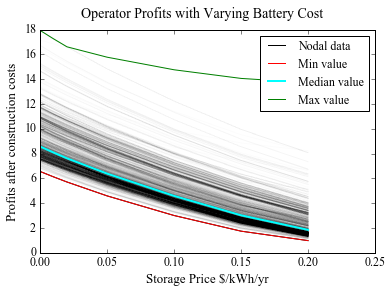

In [29]:
myDf = profitDf
x = alphaSet

ax = plt.subplot()
# plt.plot(x,myDf.transpose(),alpha=0.01, color='black')
dataHdl, = plt.plot(x,myDf.min(), color='black') # This will be covered up; we just use this for the legend
minHdl, = plt.plot(x,myDf.min(), color='red')
maxHdl, = plt.plot(x,myDf.max(), color='green')
medHdl, = plt.plot(x,myDf.median(), color='cyan',linewidth=2)

for label in (ax.get_xticklabels() + ax.get_yticklabels()):
    #label.set_fontname('Arial')
    label.set_fontsize(fs)

plt.xlabel('Price sensitivity alpha',fontsize=fs+1)
plt.ylabel('Profits after construction costs',fontsize=fs+1)
plt.suptitle('Operator Profits with Varying Price Sensitivity',fontsize=fs+2)
plt.legend([dataHdl,minHdl,medHdl, maxHdl],['Nodal data','Min value','Median value','Max value'],loc='upper right',fontsize=fs)
# plt.savefig('Plots/VaryingAlpha_storageProfit.pdf',bbox_inches='tight')
#plt.savefig('kwhValue.png', dpi=300, bbox_inches='tight')